In [2]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("ComplexHeatmap")
# install.packages(c('ClusterR','tidyverse'))
suppressMessages(require(ComplexHeatmap))
suppressMessages(require(tidyverse))
suppressMessages(require(data.table))
require(RColorBrewer)
require(ClusterR)
require(pracma)

In [42]:
(meta.dat <- fread("../data_processed/meta_data.csv") %>% mutate(dpi = as.factor(`Day Post-Infection`), 
    Age = factor(`Host Age Category`, levels = c("young", "adult", "aged")), Strain = as.factor(`Viral Strain`)) %>% 
    select("Time_BiosetID", Age, Strain, dpi) ) %>% 
    summary

 Time_BiosetID         Age                Strain    dpi    
 Length:74          young:28   SARS-CoV-ic   : 4   0.5: 6  
 Class :character   adult:37   SARS-CoV-MA15 :54   1  :15  
 Mode  :character   aged : 9   SARS-CoV-MA15e: 7   2  :19  
                               SARS-CoV-MA15g: 7   4  :19  
                               SARS-CoV-TOR-2: 2   7  :15  

In [12]:
(dat <- fread('../data_processed/plot_dat.csv') %>%column_to_rownames('V1')) %>%  head(1)
dat %>% dim

(glist <- fread("bootstrap_features_selected.csv", header = T) %>% column_to_rownames("gene")) %>% 
    head(1)

,0.5_867451,0.5_867454,0.5_867457,0.5_867478,0.5_867481,0.5_867484,1_926614,1_494014,1_494017,1_494020,⋯,7_685178,7_685217,7_821662,7_823408,7_839434,7_839446,7_833455,7_840319,7_834112,7_995287
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
March1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 10564    74

,counts,avg_weight,std_weight
,<int>,<dbl>,<dbl>
Cdca5,100,0.1207555,0.07426241


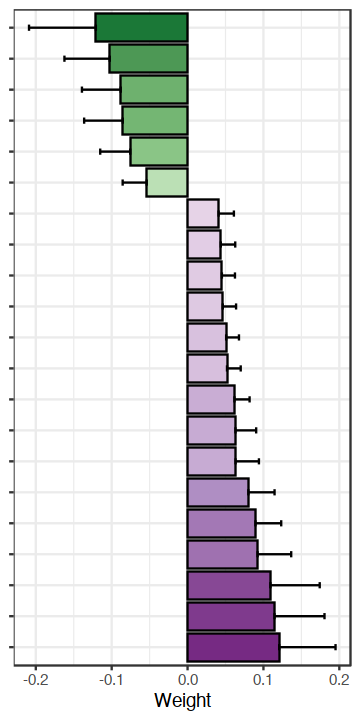

In [13]:
options(repr.plot.width = 3, repr.plot.height = 6)

p.weight_bar = ggplot(glist %>% rownames_to_column("gene") %>% mutate(gene = factor(gene, 
    levels = glist %>% rownames)), aes(gene, avg_weight, fill = avg_weight)) + geom_bar(stat = "identity", 
    color = "black") + scale_fill_distiller(palette = "PRGn") + geom_errorbar(aes(ymin = avg_weight, 
    ymax = ifelse(avg_weight > 0, avg_weight + std_weight, avg_weight - std_weight)), 
    width = 0.2, position = position_dodge(0.9)) + coord_flip() + theme_bw() + theme(legend.position = "none", 
    axis.text.y = element_blank(), axis.title.y = element_blank()) + ylab(label = "Weight")
p.weight_bar

In [16]:
df_col_anno %>% head()

,time,stage
,<chr>,<chr>
0.5_867451,0.5,early
0.5_867454,0.5,early
0.5_867457,0.5,early
0.5_867478,0.5,early
0.5_867481,0.5,early
0.5_867484,0.5,early


In [40]:
meta.dat  %>% head

,Age,Strain,dpi
,<fct>,<fct>,<fct>
0.5_867451,aged,SARS-CoV-MA15,0.5
0.5_867454,aged,SARS-CoV-MA15e,0.5
0.5_867457,aged,SARS-CoV-MA15g,0.5
0.5_867478,young,SARS-CoV-MA15,0.5
0.5_867481,young,SARS-CoV-MA15e,0.5
0.5_867484,young,SARS-CoV-MA15g,0.5


In [74]:
brewer.pal(n = 8, "Set2")[4]

[1] "#E78AC3"

[1] "#FB8072"

In [85]:
table(df_col_anno$Strain)


   SARS-CoV-ic  SARS-CoV-MA15 SARS-CoV-MA15e SARS-CoV-MA15g SARS-CoV-TOR-2 
             4             54              7              7              2 

Joining, by = "Time_BiosetID"

Warning message:
“The input is a data frame, convert it to the matrix.”


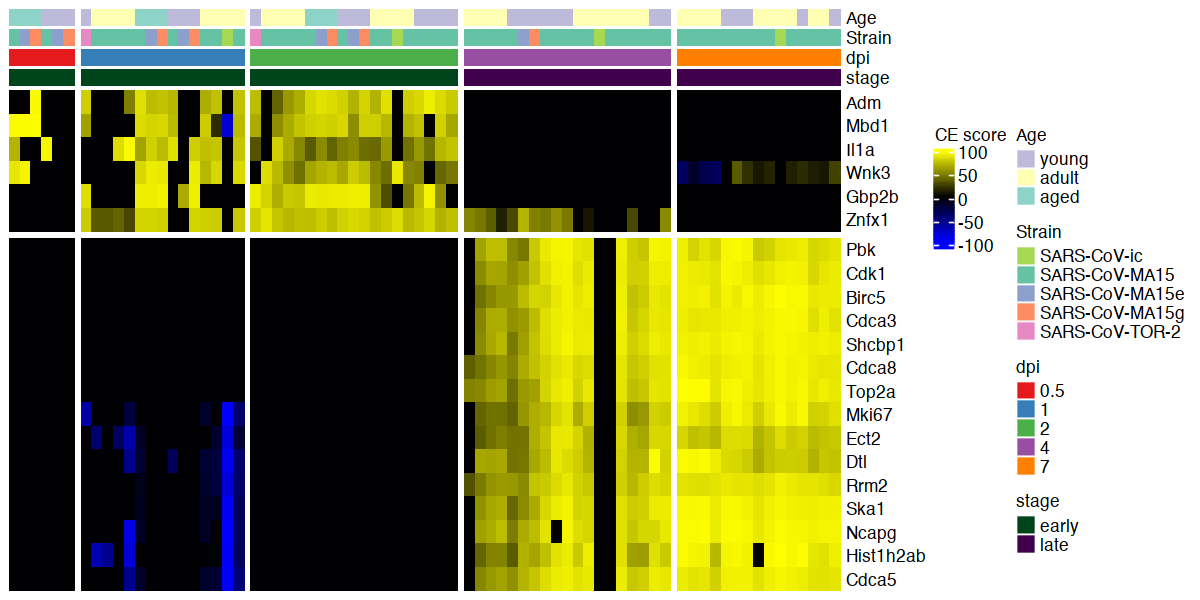

In [86]:
options(repr.plot.width = 10, repr.plot.height = 5)
n = 0
anno_colors <- list(stage = c(early = brewer.pal(n = 11, "PRGn")[11 - n], late = brewer.pal(n = 11, 
    "PRGn")[1 + n]), dpi = c(`0.5` = brewer.pal(n = 9, "Set1")[1], `1` = brewer.pal(n = 9, 
    "Set1")[2], `2` = brewer.pal(n = 9, "Set1")[3], `4` = brewer.pal(n = 9, "Set1")[4], 
    `7` = brewer.pal(n = 9, "Set1")[5]), Strain = c(`SARS-CoV-MA15` = brewer.pal(n = 8, 
    "Set2")[1], `SARS-CoV-MA15g` = brewer.pal(n = 8, "Set2")[2], `SARS-CoV-MA15e` = brewer.pal(n = 8, 
    "Set2")[3], `SARS-CoV-TOR-2` = brewer.pal(n = 8, "Set2")[4], `SARS-CoV-ic` = brewer.pal(n = 8, 
    "Set2")[5]), Age = c(aged = brewer.pal(n = 12, "Set3")[1], adult = brewer.pal(n = 12, 
    "Set3")[2], young = brewer.pal(n = 12, "Set3")[3]))

pal_atac <- colorRampPalette(c("#3361A5", "#248AF3", "#14B3FF", "#88CEEF", "#C1D5DC", 
    "#EAD397", "#FDB31A", "#E42A2A", "#A31D1D"))(100)
pal_atac <- colorRampPalette(c("blue", "black", "yellow"))(100)

col.gap = dat %>% colnames %>% sapply(., function(x) (strsplit(x, split = "_") %>% 
    unlist)[1]) %>% table %>% cumsum

df_col_anno = data.frame(col_name = dat %>% colnames) %>% separate(col_name, c("time", 
    "s"), remove = F, sep = "_") %>% mutate(stage = ifelse(time %in% c("0.5", "1", 
    "2"), "early", "late")) %>% select(-s) %>% column_to_rownames("col_name")
df_col_anno <- df_col_anno %>% rownames_to_column("Time_BiosetID") %>% left_join(meta.dat) %>% 
    column_to_rownames("Time_BiosetID") %>% select(-time) %>% select(stage, dpi, 
    Strain, Age)


pheatmap(dat[glist %>% rownames %>% rev, ], annotation_col = df_col_anno, name = "CE score", 
    annotation_colors = anno_colors, show_colnames = F, border_color = NA, gaps_col = col.gap, 
    scale = "none", color = pal_atac, cluster_rows = F, cluster_cols = F, show_rownames = T, 
    gaps_row = which((glist$avg_weight %>% rev) > 0)[1] - 1)